In [4]:
from google.colab import drive
import os

# Mount Google Drive

drive.mount("/content/drive", force_remount=True)

%cd "/content/drive/MyDrive/Selected_Topics_HW1/"

Mounted at /content/drive
/content/drive/MyDrive/Selected_Topics_HW1


In [ ]:
# extract data

!tar -xzvf "/content/drive/MyDrive/Selected_Topics_HW1/hw1-data.tar.gz" -C "/content/drive/MyDrive/Selected_Topics_HW1/data/"

In [5]:
#import splitfolders
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from collections import OrderedDict
from datetime import datetime
from PIL import Image
from skimage import img_as_float

In [6]:
import re
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    return sorted(data, key=alphanum_key)

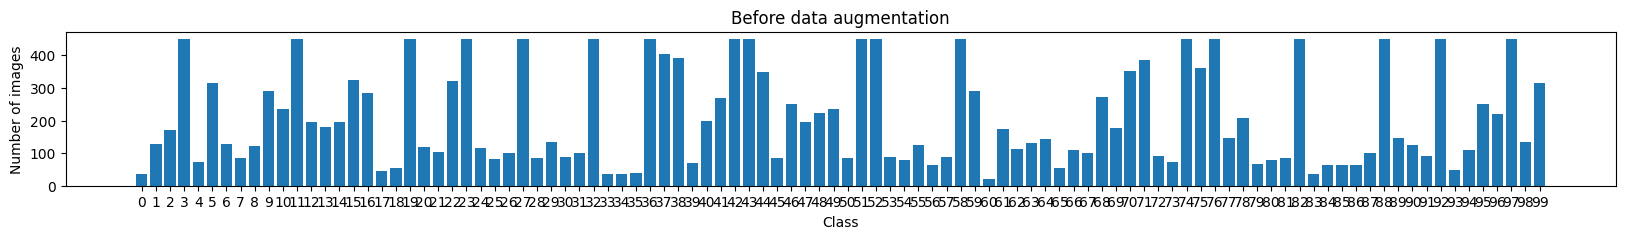

In [7]:
DATA_DIR = "/content/drive/MyDrive/Selected_Topics_HW1/data/data/train/"
img_data = {}

# display number of images in each class in training folder as a bar plot
lst = os.listdir(DATA_DIR)
lst = sorted_alphanumeric(lst)

for folder in lst:
    img_path = DATA_DIR + folder + '/'
    img_data[folder] = [img_path + img for img in os.listdir(img_path)]

num_img = [len(v) for k,v in img_data.items()]
plt.figure(figsize=(20,2))
plt.bar(img_data.keys(), num_img)
plt.title("Before data augmentation")
plt.ylabel('Number of images')
plt.xlabel('Class')
plt.show()

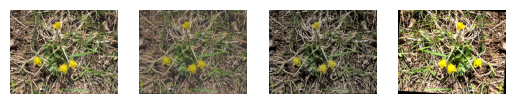

In [ ]:
image_transforms = transforms.Compose(
    [
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ColorJitter(0.4, 0.4, 0.4),
        transforms.ToTensor()
    ]
)

img = Image.open(img_data['0'][0])
fig, axarr = plt.subplots(1,4)
aug_test = [image_transforms(img).permute(1, 2, 0) for i in range(3)]
for ax, im in zip(axarr, [img]+aug_test):
    ax.imshow(im)
    ax.axis('off')
plt.show()

In [ ]:
DATA_DIR = "/content/drive/MyDrive/Selected_Topics_HW1/data/data/"

train_data = {}

for folder in os.listdir(DATA_DIR+'train/'):
    img_path = DATA_DIR+'train/' + folder + '/'
    train_data[folder] = [img_path + img for img in os.listdir(img_path)]

max_num_img = max([len(v) for k,v in train_data.items()])
print(f"Number of images in largest class: {max_num_img}")

Number of images in largest class: 450


In [ ]:
# create a copy of train dataset before data augmentation
%cp -av "/content/drive/MyDrive/Selected_Topics_HW1/data/data/train/" "/content/drive/MyDrive/Selected_Topics_HW1/data/data/train_augmented"

In [ ]:
from torchvision.utils import save_image

for folder, path_list in train_data.items():
    if len(path_list) < max_num_img:
        sets = (max_num_img-len(path_list)) // len(path_list)
        mod = (max_num_img-len(path_list)) % len(path_list)
        for i, path in enumerate(path_list):
            img = Image.open(path)
            img = img.convert('RGB')
            sets_iter = sets + 1 if i < mod else sets
            for k in range(sets_iter):
                save_image(image_transforms(img), f'{DATA_DIR}/train_augmented/{folder}/augmented_{i}_{k}.jpg')

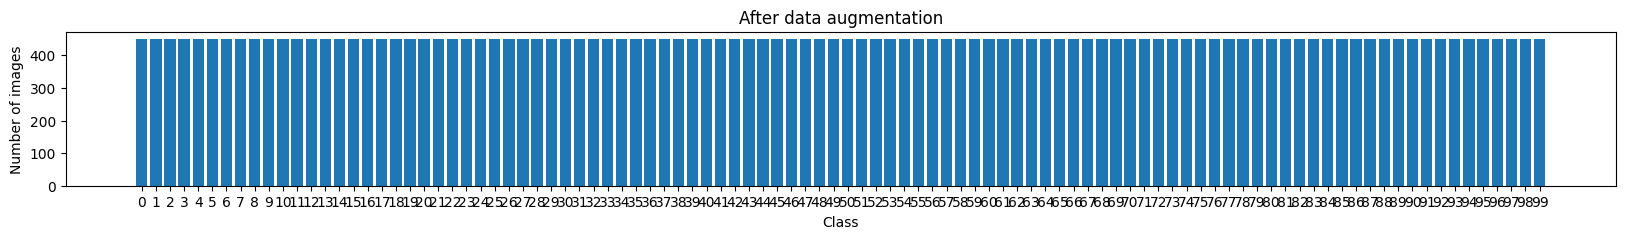

In [ ]:
DATA_DIR = "/content/drive/MyDrive/Selected_Topics_HW1/data/data/train_augmented/"
img_data = {}

# after data augmentation
lst = os.listdir(DATA_DIR)
lst = sorted_alphanumeric(lst)

for folder in lst:
    img_path = DATA_DIR + folder + '/'
    img_data[folder] = [img_path + img for img in os.listdir(img_path)]

num_img = [len(v) for k,v in img_data.items()]
plt.figure(figsize=(20,2))
plt.bar(img_data.keys(), num_img)
plt.title("After data augmentation")
plt.ylabel('Number of images')
plt.xlabel('Class')
plt.show()

In [8]:
DATA_DIR = "/content/drive/MyDrive/Selected_Topics_HW1/data/data/"

im_size = 224
transformation = transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(im_size),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ])

# Load data
train_data = datasets.ImageFolder(
    DATA_DIR + "train_augmented", transform=transformation
)
val_data = datasets.ImageFolder(
    DATA_DIR + "val", transform=transformation
)

# Creating data samplers and loaders:
BATCH_SIZE = 32
train_loader = DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True
)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

# Label mapping
class_mapping = train_data.class_to_idx
num_classes = len(class_mapping)
print(num_classes)
print(len(train_loader))


100
1407


In [9]:
model = models.resnet50(weights=True)
print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 173MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

25557032


In [10]:
# using gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [11]:
print("Original final layer")
print(model.fc)

# Build custom classifier
num_classes = len(class_mapping)
num_ftrs = model.fc.in_features
classifier = nn.Sequential(
    OrderedDict(
        [
            ("fc", nn.Linear(num_ftrs, num_classes)),
            ("output", nn.LogSoftmax(dim=1)),
        ]
    )
)
model.fc = classifier

print("\nModified final layer")
print(model.fc)

Original final layer
Linear(in_features=2048, out_features=1000, bias=True)

Modified final layer
Sequential(
  (fc): Linear(in_features=2048, out_features=100, bias=True)
  (output): LogSoftmax(dim=1)
)


In [12]:
from tqdm import tqdm
def validation(model, criterion, val_loader, device):
    val_loss = 0
    accuracy = 0
    for images, labels in iter(tqdm(val_loader, desc="Validation", leave=True)):
        images= images.to(device)
        labels = labels.to(device)
        output = model.forward(images)
        val_loss += criterion(output, labels).item()

        probabilities = torch.exp(output)

        equality = labels.data == probabilities.max(dim=1)[1]
        accuracy += equality.type(torch.FloatTensor).mean()

    return val_loss, accuracy

def train_model(model, optimizer, criterion, train_loader, val_loader, device, epochs=50):
    plot_training = []
    plot_validation = []
    start_epoch = 0
    for e in range(start_epoch, epochs):
        model.train()
        running_loss = 0
        for images, labels in iter(tqdm(train_loader, desc="Training", leave=True)):
              optimizer.zero_grad()
              images= images.to(device)
              labels = labels.to(device)
              output = model.forward(images)
              loss = criterion(output, labels)
              loss.backward()
              optimizer.step()

              running_loss += loss.item()

        # Evaluate performance of each epoch
        model.eval()

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            validation_loss, accuracy = validation(model, criterion, val_loader, device)

        print(
            "Epoch: {}/{}.. ".format(e + 1, epochs),
            "Training Loss: {:.3f}.. ".format(running_loss),
            "Validation Loss: {:.3f}.. ".format(
                validation_loss / len(val_loader)
            ),
            "Validation Accuracy: {:.3f}".format(accuracy / len(val_loader)),
        )

        plot_training.append(running_loss)
        plot_validation.append(validation_loss / len(val_loader))
        save_checkpoint(model, class_mapping, f'resnet50_LR=0.0001_epoch{e}')

    plt.plot(range(len(plot_training)), plot_training, label='training')
    plt.plot(range(len(plot_validation)), plot_validation, label='validation')
    plt.legend()
    plt.show()


    return model

In [ ]:
def save_checkpoint(model, class_mapping, arch):
    """
    Save trained model weights.

    Input:
    arch(str): Model architecture
    """

    checkpoint = {
        "arch": arch,
        "class_to_idx": class_mapping,
        "model_state_dict": model.state_dict(),
    }

    timestamp = datetime.now().date().strftime("%Y%m%d")
    torch.save(checkpoint, f"/content/drive/MyDrive/Selected_Topics_HW1/{timestamp}_{arch}.pth")

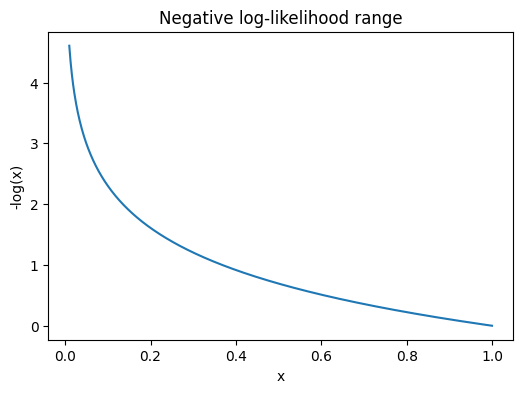

In [ ]:
x = np.arange(0.01, 1.0, 0.001)
y = -np.log(x)

fig,ax = plt.subplots(figsize=(6,4))
ax.plot(x,y)
plt.ylabel('-log(x)')
plt.xlabel('x')
plt.title('Negative log-likelihood range')
plt.show()

In [ ]:
# Loss function and gradient descent
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

In [ ]:
# Train model
model_r = model.to(device)
model_r = train_model(model_r, optimizer, criterion, train_loader, val_loader, device)

In [14]:
def load_checkpoint(filepath, class_mapping):
    """
    Loads a checkpoint and rebuilds the model.

    Input:
    filepath(str): Relative path to model checkpoint
    """
    if os.path.exists(filepath):
        checkpoint = torch.load(filepath)
        num_classes = len(class_mapping)

        if "resnet50" in checkpoint["arch"]:
            model = models.resnet50(pretrained=True)
            num_ftrs = model.fc.in_features
            classifier = nn.Sequential(
            OrderedDict(
                [
                    ("fc", nn.Linear(num_ftrs, num_classes)),
                    ("output", nn.LogSoftmax(dim=1)),
                ]
            )
        )
            model.fc = classifier

        else:
            return print("Architecture not recognized.")

        for param in model.parameters():
            param.requires_grad = False

        model.class_to_idx = checkpoint["class_to_idx"]
        model.load_state_dict(checkpoint["model_state_dict"])

        return model

    else:
        print("No such checkpoint found.")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Validation: 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


validation accuracy =  0.7010416507720947


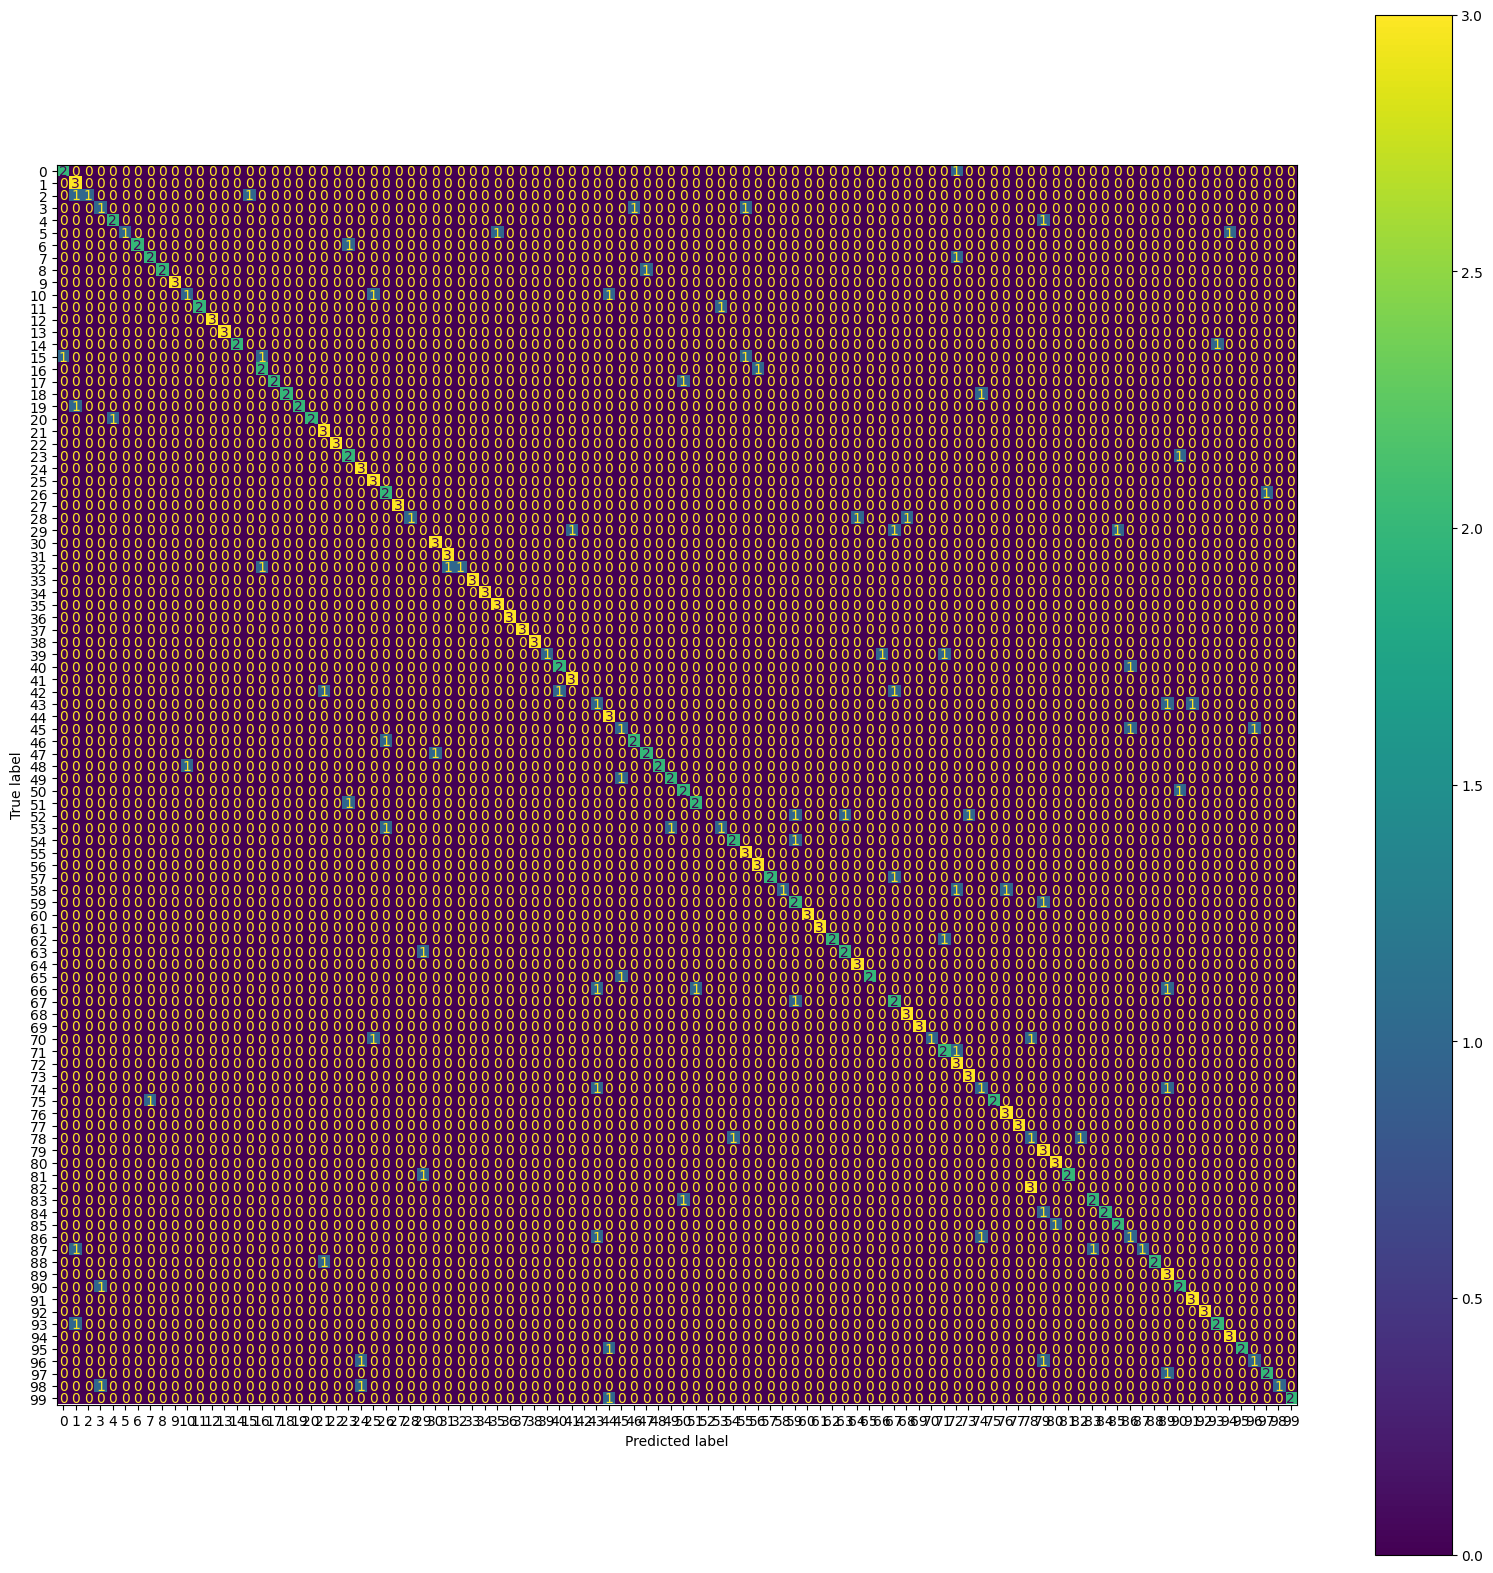

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model_checkpoint = "/content/drive/MyDrive/Selected_Topics_HW1/best_model_with_augmentation.pth"
model = load_checkpoint(model_checkpoint, class_mapping)
model = model.to(device)

model.eval()

accuracy = 0
ground_truth = []
predictions = []

for images, labels in iter(tqdm(val_loader, desc="Validation", leave=True)):
        images= images.to(device)
        labels = labels.to(device)
        output = model.forward(images)

        probabilities = torch.exp(output)

        equality = labels.data == probabilities.max(dim=1)[1]
        equality = labels.data == probabilities.max(dim=1)[1]
        accuracy += equality.type(torch.FloatTensor).mean()

        ground_truth += labels.tolist()
        predictions += probabilities.max(dim=1)[1].tolist()

accuracy = accuracy.item() / len(val_loader)
print('validation accuracy = ', accuracy)

cm = confusion_matrix(ground_truth, predictions)

disp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(20,20))
disp.plot(ax=ax)

In [23]:
from torch.utils.data import Dataset
import cv2
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from skimage import io, transform

# create a custom dataset for test

class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Arguments:
            root_dir (string): Directory with all test images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.files = os.listdir(root_dir)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir,
                                self.files[idx])
        image = io.imread(img_name)

        if self.transform:
            image = self.transform(image)

        sample = {'image': image, 'name': self.files[idx].split(".")[0]}
        return sample

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['name']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image)}

DATA_DIR = "/content/drive/MyDrive/Selected_Topics_HW1/data/data/test/test"

im_size = 224
transformation = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize(im_size),
                transforms.CenterCrop(im_size),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ])

 # Load test data
test_data = TestDataset(DATA_DIR, transformation)

# Creating data samplers and loaders:
BATCH_SIZE = 1
test_loader = DataLoader(
    test_data, batch_size=BATCH_SIZE, shuffle=False
)

for i, sample in enumerate(test_data):
    print(i, sample['image'].size(), sample['name'])

    if i == 2:
        break

0 torch.Size([3, 224, 224]) 04062424-03f2-4bcc-b603-076353f75f2e
1 torch.Size([3, 224, 224]) fc5ff85f-2b0c-4b37-9c9b-54a429186b56
2 torch.Size([3, 224, 224]) 430bc2d1-1b48-4910-b457-b55ae7157a4d


In [34]:
from tqdm import tqdm
def test(model, test_loader, device):
    test_pred_list = []
    img_data_list = []
    for data in iter(tqdm(test_loader, desc="Testing", leave=True)):
        images = data['image'].to(device)
        names = data['name']
        output = model.forward(images)
        probabilities = torch.exp(output)
        pred_index = probabilities.max(dim=1)[1]
        test_pred_list.append(pred_index.tolist()[0])
        img_data_list.append(names[0].split(".")[0])
    print('Dump file...')
    dict = {'image_name': img_data_list, 'pred_label': test_pred_list}

    df = pd.DataFrame(dict)
    df.to_csv('prediction.csv', index=False)

In [35]:
model_checkpoint = "/content/drive/MyDrive/Selected_Topics_HW1/best_model_with_augmentation.pth"
model = load_checkpoint(model_checkpoint, class_mapping)
model = model.to(device)
model = test(model, test_loader, device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Testing: 100%|██████████| 2344/2344 [25:28<00:00,  1.53it/s]


Dump file...
